Who is Paying for the Primaries?
-------------------------------------
(A work in progress)

The Federal Elections Committee requires all candidates to submit quarterly reports detailing individual contributions as well as a list of expenses. These are available online at (http://www.fec.gov/press/resources/2016presidential_form2nm.shtml). I've pulled all filings for the Republican candidates plus Clinton up through July (some candidates weren't yet officially registered, so they didn't have to file). You can find all of the reports in a spreadsheet at [insert].

The data arrives in 1 CSV per candidate. After inspecting the data, it appears that the first two rows are meaningless.

In [71]:
import pandas as pd
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
df_rosetta = pd.read_excel("C:/Users/riguy/SkyDrive/Documents/FEC_Defns.xlsx", sheetname="all versions", header=None)
df_rosetta = df_rosetta[df_rosetta[0] == "v8.1"]

In [7]:
all_candidates = pd.read_excel("C:/Users/riguy/SkyDrive/Documents/RNC_contributions.xlsx", sheetname=None, skiprows=2, header=None)

In [10]:
for candidate, data in all_candidates.iteritems():
    data["candidate"] = candidate

In [16]:
# Get the form types
all_candidates["Jindal"].groupby(0).agg({1: len})

,1
0,
SA17A,258
SA17C,1
SB23,34


What I know about the form types:
* SA17A is individual contributions
* SA17C appears to be contributions from other organizations.
* SB28A is refunds to individuals

Some of this was derived from this blog: http://www.mornin.org/blog/wrangling-fecs-2012-presidential-campaign-finance-/

The meaning of the columns in each row is determined by the form type as defined in df_rosetta above, which I got from the fec at http://www.fec.gov/finance/disclosure/ftpefile.shtml. I am pretty sure we are using v8.1 of the standard.


I actually want to pivot the data to organized by candidate to organized by type of line. This next section does exactly that.

In [18]:
def build_subset(df_individual, key="SA"):
    columns = df_rosetta[df_rosetta[1] == key][range(2, len(df_rosetta[1]))].as_matrix()
    columns = [a.split('-')[1].split('{')[0].replace(' ', '') for a in columns[0] if not pd.isnull(a)]
    df_individual = df_individual[range(len(columns)) + ["candidate"]]
    columns = columns + ["candidate"]
    df_individual.columns = columns
    return df_individual

In [27]:
individual_contributions = list()
for k, v in all_candidates.iteritems():
    v_i = v[v[0] == "SA17A"]
    v_i = build_subset(v_i, "SA")
    individual_contributions.append(v_i)

In [33]:
df_individual = pd.concat(individual_contributions)
df_individual_rnc = df_individual[df_individual.candidate != "DNC_Clinton"]

In [163]:
contributions_by_state = df_individual_rnc.groupby("CONTRIBUTORSTATE").agg({"CONTRIBUTIONAMOUNT": sum})\
    .sort("CONTRIBUTIONAMOUNT", ascending=False)
contributions_by_state["RelativeContribution"] = contributions_by_state.CONTRIBUTIONAMOUNT / contributions_by_state.CONTRIBUTIONAMOUNT.sum()
contributions_by_state_dict = contributions_by_state.RelativeContribution.to_dict()

In [164]:
contributions_by_state.head()

,CONTRIBUTIONAMOUNT,RelativeContribution
CONTRIBUTORSTATE,,
TX,9065765.40,0.255642
FL,5314168.12,0.149852
CA,4075912.85,0.114935
NY,2426093.39,0.068412
SC,1146856.96,0.032340


Now we've got total contributions by state. The next two cells are setup. First, I need to grab a map of states to their abbreviations. Then I'll set up our plot function, which I pretty much copied directly from stackoverflow.

In [171]:
import requests
from json import loads
f = requests.get("https://gist.githubusercontent.com/mshafrir/2646763/raw/8b0dbb93521f5d6889502305335104218454c2bf/states_hash.json")
states = loads(f.content)
states['DC'] = 'District of Columbia'  # was Of not of. data is hard :)
rev_states = dict([(v, k) for k, v in states.iteritems()])

C:\Anaconda\lib\site-packages\requests\packages\urllib3\util\ssl_.py:90: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning


In [207]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon

def build_basic_map(contributions_dict, multiplier = 3):
    # create the map
    map = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

    # load the shapefile, use the name 'states'
    map.readshapefile('./data/st99_d00', name='states', drawbounds=True)

    # collect the state names from the shapefile attributes so we can
    # look up the shape obect for a state by it's name
    state_names = []
    for shape_dict in map.states_info:
        state_names.append(shape_dict['NAME'])

    ax = plt.gca() # get current axes instance

    # get Texas and draw the filled polygon
    for key in states:
        try:
            seg = map.states[state_names.index(states[key])]
            poly = Polygon(seg, facecolor=plt.cm.hot_r(contributions_dict[key] * multiplier) ,edgecolor=None)
            ax.add_patch(poly)
        except ValueError:
            # print key
            pass # I printed these once. They are micronesia, ect.
    return plt


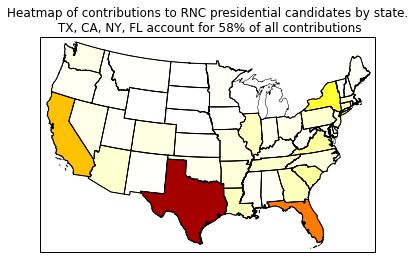

In [208]:
plt = build_basic_map(contributions_by_state_dict)
plt.title("Heatmap of contributions to RNC presidential candidates by state.\n TX, CA, NY, FL account for 58% of all contributions")
plt.show()

It should not be too surprising that TX, CA, NY, and FL are the top four: they are also the top four states by population, and Texas and Florida in particular have 2 candidates *each* in the RNC race. It may be interesting to normalize contributions by population.

In [168]:
# %load "data/populations_2014_wikipedia.py"
# I got this from https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_population
populations_2014_wikipedia = {
	"California": 38802500,
	"Texas": 26956958,
	"Florida": 19893297,
	"New York": 19746227,
	"Illinois": 12880580,
	"Pennsylvania": 12787209,
	"Ohio": 11594163,
	"Georgia": 10097343,
	"North Carolina": 9943964,
	"Michigan": 9909877,
	"New Jersey": 8938175,
	"Virginia": 8326289,
	"Washington": 7061530,
	"Massachusetts": 6745408,
	"Arizona": 6731484,
	"Indiana": 6596855,
	"Tennessee": 6549352,
	"Missouri": 6063589,
	"Maryland": 5976407,
	"Wisconsin": 5757564,
	"Minnesota": 5457173,
	"Colorado": 5355866,
	"Alabama": 4849377,
	"South Carolina": 4832482,
	"Louisiana": 4649676,
	"Kentucky": 4413457,
	"Oregon": 3970239,
	"Oklahoma": 3878051,
	"Puerto Rico": 3548397,
	"Connecticut": 3596677,
	"Iowa": 3107126,
	"Mississippi": 2994079,
	"Arkansas": 2966369,
	"Utah": 2942902,
	"Kansas": 2904021,
	"Nevada": 2839098,
	"New Mexico": 2085572,
	"Nebraska": 1881503,
	"West Virginia": 1850326,
	"Idaho": 1634464,
	"Hawaii": 1419561,
	"Maine": 1330089,
	"New Hampshire": 1326813,
	"Rhode Island": 1055173,
	"Montana": 1023579,
	"Delaware": 935614,
	"South Dakota": 853175,
	"North Dakota": 739482,
	"Alaska": 736732,
	"District of Columbia": 658893,
	"Vermont": 626562,
	"Wyoming": 584153
}

In [182]:
state_populations = pd.DataFrame([{'State': k, 'Pop': v} for k, v in populations_2014_wikipedia.iteritems()])
state_populations["RelativePop"] = state_populations.Pop / state_populations.Pop.sum()
state_populations["StateAbbrev"] = state_populations.State.apply(lambda x: rev_states.get(x, ""))
state_populations.head()

,Pop,State,RelativePop,StateAbbrev
0,2994079,Mississippi,0.009287,MS
1,3878051,Oklahoma,0.012028,OK
2,935614,Delaware,0.002902,DE
3,5457173,Minnesota,0.016926,MN
4,12880580,Illinois,0.039951,IL


In [188]:
contributions_by_state_with_pop = contributions_by_state.merge(state_populations, right_index=False, right_on="StateAbbrev", left_index=True, how="inner")
# NOTE: I checked this with an outer join first. Didn't see anything wonky.

In [192]:
contributions_by_state_with_pop["NormalizedContribution"] = contributions_by_state_with_pop.RelativeContribution / contributions_by_state_with_pop.RelativePop

In [196]:
contributions_by_state_with_pop.sort('NormalizedContribution', ascending=False).head(7)

,CONTRIBUTIONAMOUNT,RelativeContribution,Pop,State,RelativePop,StateAbbrev,NormalizedContribution
46,495043.60,0.013960,658893,District of Columbia,0.002044,DC,6.830600
9,9065765.40,0.255642,26956958,Texas,0.083612,TX,3.057482
41,5314168.12,0.149852,19893297,Florida,0.061703,FL,2.428616
39,1146856.96,0.032340,4832482,South Carolina,0.014989,SC,2.157592
12,754712.22,0.021282,3596677,Connecticut,0.011156,CT,1.907701
5,497570.72,0.014031,2966369,Arkansas,0.009201,AR,1.524965
8,768502.53,0.021671,4649676,Louisiana,0.014422,LA,1.502633


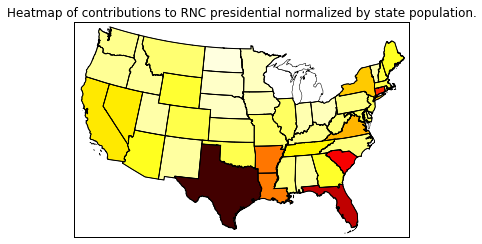

In [209]:
contributions_by_state_with_pop_dict = contributions_by_state_with_pop.set_index('StateAbbrev').NormalizedContribution.to_dict()
plt = build_basic_map(contributions_by_state_with_pop_dict, .3)
plt.title("Heatmap of contributions to RNC presidential normalized by state population.")
plt.show()

Normalizing by population, we see a few more interesting facts emerge.

First of all, Texas is still king. It's large, has a robust economy, two candidates, and it tends to swing right. Florida is also pretty active, which again makes sense given its candidates.

Arkansas and Lousiana both have a man in the race. As we'll see later, those states' contributions swing heavily towards "their man". This early in the cycle, it makes sense that governors or former governors would be hitting up their home turf.

South Carolina also has a candidate, which may explain their very high contribution per person relative to other states. It's also an early state, which is something we should pursue further.

Connecticut lights up. Finance perhaps? Should explore more fully.

The real winner(?) here is D.C. with a contribution/person that is twice that the next closest state. 

0.78482838554767076